In [1]:
import torch
import torch.nn as nn
import numpy as np

In [2]:
# 데이터 준비
# 삼각함수 파형으로 데이터를 임의로 설정하였습니다.
data_size = 10000
time_steps = np.linspace(0, 100, data_size, dtype=np.float32)

sensor_cnt = 3

data_sensor01 = np.sin(time_steps)
data_sensor02 = np.cos(time_steps)
# 탄젠트 함수인데 (-2,2) 까지 경계선을 정한 넘파이 배열
data_sensor03 = np.clip(np.tan(time_steps), -2, 2)

data_light = (data_sensor01 + data_sensor02) / np.sqrt(2) + data_sensor03

# PyTorch Tensor로 변환하기 위한 전처리
ndata_s01 = data_sensor01.reshape(data_size, 1)
ndata_s02 = data_sensor02.reshape(data_size, 1)

ndata_s03 = data_sensor03.reshape(data_size, 1)

ndata_light = data_light.reshape(data_size,1)
mdata = np.concatenate((ndata_s01, ndata_s02, ndata_s03, ndata_light), axis=1)

In [3]:
def load_data(stock, look_back):
    data_raw = stock
    data = []

    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back):
        data.append(data_raw[index: index + look_back])

    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);

    x_train = data[:train_set_size,:-1,:sensor_cnt]
    y_train = data[:train_set_size,-1,sensor_cnt:]

    x_test = data[train_set_size:,:-1, :sensor_cnt]
    y_test = data[train_set_size:,-1,sensor_cnt:]

    return [x_train, y_train, x_test, y_test]

# look back 의 의미 : 특정 크기의 단위만큼 이전 값을 고려한다
# 단위는 초(seconds) 가 될 것이라 예상
look_back = 10 # choose sequence length
x_train, y_train, x_test, y_test = load_data(mdata, look_back)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (7992, 9, 3)
y_train.shape =  (7992, 1)
x_test.shape =  (1998, 9, 3)
y_test.shape =  (1998, 1)


In [4]:
# make training and test sets in torch
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [5]:
y_train.size(),x_train.size()

(torch.Size([7992, 1]), torch.Size([7992, 9, 3]))

In [6]:
# LSTM 모델 정의
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:,-1,:])
        return out

In [7]:
# 모델 및 손실 함수, 옵티마이저 초기화
input_size = sensor_cnt  # 입력 데이터의 열 수
hidden_size = 64 # 은닉 층의 개수
output_size = 1  # 마지막 열 값(data_light)을 예측
num_layers = 2
model = LSTM(input_size, hidden_size, num_layers, output_size)
# 손실함수 : MSE (Mean Squared Error)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [8]:
# 훈련 루프
num_epochs = 100
for epoch in range(num_epochs):
    y_train_pred = model(x_train)
    optimizer.zero_grad()
    loss = criterion(y_train_pred, y_train)

    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print('훈련 완료!')

Epoch [10/100], Loss: 1.8208
Epoch [20/100], Loss: 0.6373
Epoch [30/100], Loss: 0.4489
Epoch [40/100], Loss: 0.2887
Epoch [50/100], Loss: 0.2275
Epoch [60/100], Loss: 0.1940
Epoch [70/100], Loss: 0.1685
Epoch [80/100], Loss: 0.1481
Epoch [90/100], Loss: 0.1295
Epoch [100/100], Loss: 0.1134
훈련 완료!


In [9]:
np.shape(y_train_pred)

torch.Size([7992, 1])

In [10]:
# # make predictions
# y_test_pred = model(x_test)

# # invert predictions
# y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
# y_train = scaler.inverse_transform(y_train.detach().numpy())
# y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
# y_test = scaler.inverse_transform(y_test.detach().numpy())

# # calculate root mean squared error
# trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
# print('Train Score: %.2f RMSE' % (trainScore))
# testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
# print('Test Score: %.2f RMSE' % (testScore))

Test Loss : 12.5585%


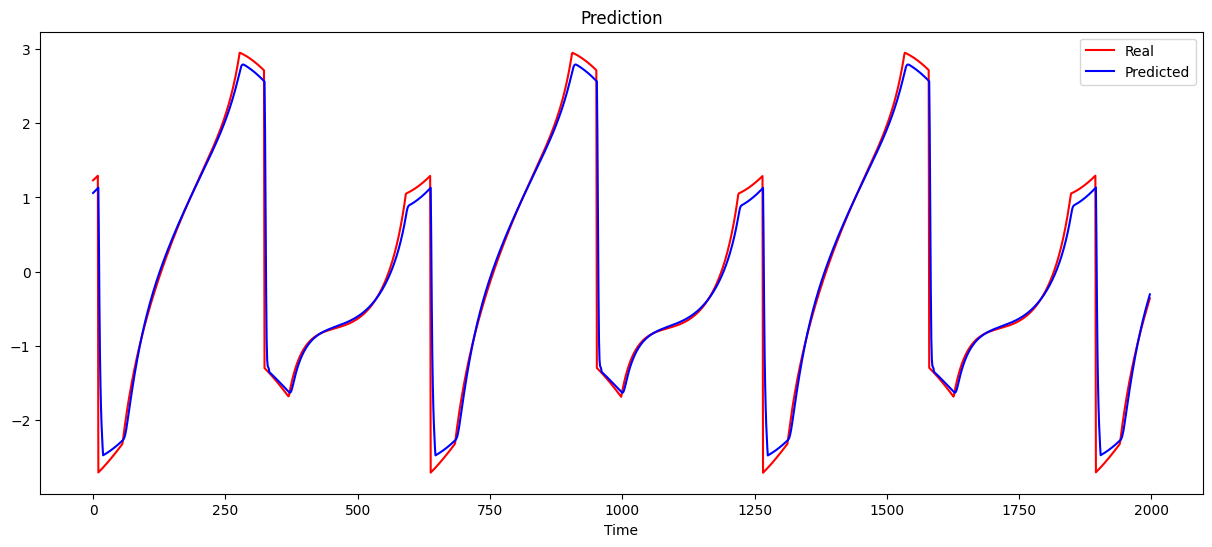

LSTM(
  (lstm): LSTM(3, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [11]:
import matplotlib.pyplot as plt

model.eval()  # 모델을 평가 모드로 설정
with torch.no_grad():
  y_test_pred = model(x_test)

test_loss = criterion(y_test, y_test_pred)
print(f'Test Loss : {test_loss.item():.4%}')

# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))

axes.plot(y_test.detach().numpy(), color = 'red', label = 'Real')
axes.plot(y_test_pred.detach().numpy(), color = 'blue', label = 'Predicted')
plt.title('Prediction')
plt.xlabel('Time')
plt.legend()
plt.show()

# 모델을 다시 학습 모드로 설정
model.train()

In [12]:
# 현재 학습한 모델 저장
torch.save(model, 'LSTM_231026.pth')

In [13]:
print(x_test.shape)

torch.Size([1998, 9, 3])


In [14]:
print(x_test[:1].shape)

torch.Size([1, 9, 3])


In [19]:
model.eval()  # 모델을 평가 모드로 설정
with torch.no_grad():
  y_test_pred = model(x_test[:1])

test_loss = criterion(y_test_pred, y_test[0])
print(f'Test Loss : {test_loss.item():.4%}')

print(y_test_pred)
print(y_test[0])
# 모델을 다시 학습 모드로 설정
model.train()

Test Loss : 2.9270%
tensor([[1.0594]])
tensor([1.2305])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


LSTM(
  (lstm): LSTM(3, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)